In [6]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import plotting as niplt
from neurosynth.base.dataset import Dataset
from base.tools import convert_nib
from scipy import interp
from base.classifiers import OnevsallClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import itertools
from base import tools
from base.plotting import nine_colors
from base.statistics import mean_roc_report
from neurosynth.analysis import classify
from joblib import Parallel, delayed

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [7]:
dataset = Dataset.load('../data/datasets/abs_60topics_filt_jul.pkl')
clf = OnevsallClassifier.load('../results/classification/newmFC_kmeans_coact_m100_pca_9_GNB_t0.05_cog_topics_60/classifier.pkl')

In [8]:
SMA = [3, 6]
dACC = [9, 5, 1, 7]
mPFC = [2, 4, 8]

all_rois = SMA + dACC + mPFC
region_names = ['SMAc', 'SMAr', 'pdMCC', 'adMCC', 'pMCC', 'aMCC', 'rACC', 'dmPFC', 'vmPFC']
regions = dict(zip(all_rois, region_names))
region_order = dict(zip(region_names, range(len(region_names))))

In [9]:
_, nine_colors_sorted = zip(*sorted(zip(all_rois, nine_colors), key=lambda tup: tup[0]))

### Peformance with all topics

In [13]:
## Overall sensitivity / specificity
all_specificity = []
for i, (predictions) in enumerate(clf.predictions):
    report = mean_roc_report(predictions)
    report['region'] = i
    all_specificity.append(report)
all_specificity = pd.DataFrame(all_specificity)
all_specificity.region += 1

all_specificity['region_name'] = all_specificity.region.map(regions)

### Bootstrapped performance with all topics

In [14]:
from sklearn.cross_validation import cross_val_predict, cross_val_score
from sklearn.utils import resample
from base.statistics import specificity_score, roc_report
from sklearn.metrics import recall_score, make_scorer, roc_auc_score
from base.plotting import bar_plot_ci

In [15]:
def resampled_roc_report(X, y, n_boot, classifier):
    X, y = resample(X, y, random_state = n_boot)
    report = roc_report(y, cross_val_predict(classifier, X, y , cv=4))
    report['n_boot'] = n_boot

    classifier = classifier.fit(X, y)
    log_odds = np.log(classifier.theta_[1] / classifier.theta_[0])
    X_1 = X[:, np.where(log_odds == log_odds.max())[0]]
    
    report_1 = roc_report(y, cross_val_predict(classifier, X_1, y , cv=4))
    report['roc_auc_1'] = report_1['roc_auc']
    report['sensitivity_1'] = report_1['sensitivity']
    report['specificity_1'] = report_1['specificity']
    
    return report

In [19]:
boot_roc_report = []
with Parallel(n_jobs=7) as parallel:
    for n_reg, (X, y) in enumerate(clf.data):
        reg_results = pd.DataFrame(parallel(delayed(
                    resampled_roc_report)(X, y, i, clf.classifier) for i in range(0, 500)))
        reg_results['region'] = n_reg + 1
        boot_roc_report.append(reg_results)
        print n_reg
boot_roc_report = pd.concat(boot_roc_report)

0
1
2
3
4
5
6
7
8


In [20]:
roc_auc = boot_roc_report.groupby(['region']).apply(lambda x: pd.Series(
        np.percentile(x.roc_auc, [2.5, 50, 97.5]))).rename(
    columns={0:'lower_roc_auc', 1:'mean_roc_auc', 2: 'upper_roc_auc'}).reset_index()

sensitivity = boot_roc_report.groupby(['region']).apply(lambda x: pd.Series(
        np.percentile(x.sensitivity, [2.5, 50, 97.5]))).rename(
    columns={0:'lower_sensitivity', 1:'mean_sensitivity', 2: 'upper_sensitivity'}).reset_index()

specificity = boot_roc_report.groupby(['region']).apply(lambda x: pd.Series(
        np.percentile(x.specificity, [2.5, 50, 97.5]))).rename(
    columns={0:'lower_specificity', 1:'mean_specificity', 2: 'upper_specificity'}).reset_index()


boot_report_grouped = pd.merge(roc_auc, pd.merge(sensitivity, specificity))
boot_report_grouped['region_name'] = boot_report_grouped.region.map(regions)
boot_report_grouped['region_order'] = boot_report_grouped.region_name.map(region_order)

boot_report_grouped = boot_report_grouped.sort_values('region_order')

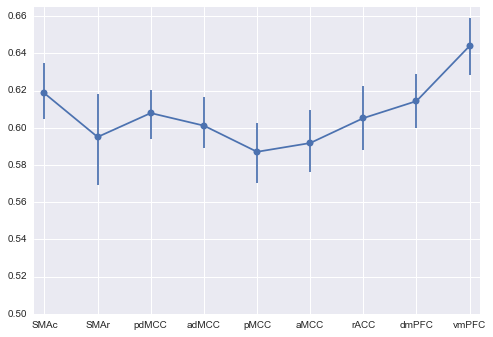

In [21]:
bar_plot_ci('mean_roc_auc', 'lower_roc_auc', 'upper_roc_auc', 'region_name', boot_report_grouped, ylim=(0.5, .665))

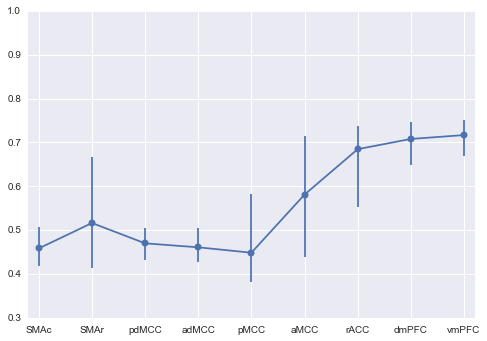

In [22]:
bar_plot_ci('mean_sensitivity', 'lower_sensitivity', 'upper_sensitivity', 'region_name', boot_report_grouped, ylim=(0.3, 1))

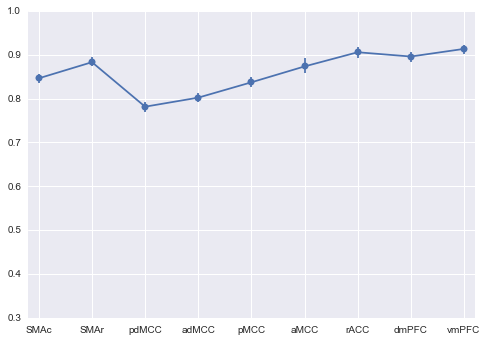

In [23]:
bar_plot_ci('mean_specificity', 'lower_specificity', 'upper_specificity', 'region_name', boot_report_grouped, ylim=(0.3, 1))

### With only 1 topic

In [24]:
roc_auc = boot_roc_report.groupby(['region']).apply(lambda x: pd.Series(
        np.percentile(x.roc_auc_1, [2.5, 50, 97.5]))).rename(
    columns={0:'lower_roc_auc', 1:'mean_roc_auc', 2: 'upper_roc_auc'}).reset_index()

sensitivity = boot_roc_report.groupby(['region']).apply(lambda x: pd.Series(
        np.percentile(x.sensitivity_1, [2.5, 50, 97.5]))).rename(
    columns={0:'lower_sensitivity', 1:'mean_sensitivity', 2: 'upper_sensitivity'}).reset_index()

specificity = boot_roc_report.groupby(['region']).apply(lambda x: pd.Series(
        np.percentile(x.specificity_1, [2.5, 50, 97.5]))).rename(
    columns={0:'lower_specificity', 1:'mean_specificity', 2: 'upper_specificity'}).reset_index()


boot_report_1_grouped = pd.merge(roc_auc, pd.merge(sensitivity, specificity))
boot_report_1_grouped['region_name'] = boot_report_1_grouped.region.map(regions)
boot_report_1_grouped['region_order'] = boot_report_1_grouped.region_name.map(region_order)

boot_report_1_grouped = boot_report_1_grouped.sort_values('region_order')

In [25]:
(boot_report_grouped.mean_sensitivity - boot_report_1_grouped.mean_sensitivity).mean()

0.4595248768423256

In [26]:
boot_report_1_grouped.mean_sensitivity.mean()

0.1009127177589503

In [35]:
boot_report_1_grouped.describe()

,region,lower_roc_auc,mean_roc_auc,upper_roc_auc,lower_sensitivity,mean_sensitivity,upper_sensitivity,lower_specificity,mean_specificity,upper_specificity,region_order
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,5.000000,0.528399,0.537326,0.547292,0.081481,0.100913,0.125712,0.808164,0.816643,0.825565,4.000000
std,2.738613,0.021798,0.023433,0.024465,0.048818,0.049868,0.048745,0.049085,0.048833,0.048266,2.738613
min,1.000000,0.508559,0.516260,0.520924,0.035545,0.056714,0.068794,0.716126,0.724620,0.734977,0.000000
25%,3.000000,0.511464,0.518339,0.529944,0.045659,0.060985,0.096169,0.795753,0.805693,0.815529,2.000000
50%,5.000000,0.519946,0.529778,0.536877,0.057383,0.082388,0.109952,0.823632,0.831841,0.839372,4.000000
75%,7.000000,0.547515,0.560419,0.568727,0.127463,0.152649,0.171333,0.839598,0.847562,0.856700,6.000000
max,9.000000,0.568918,0.579502,0.592312,0.167765,0.188482,0.212633,0.861205,0.869389,0.878083,8.000000


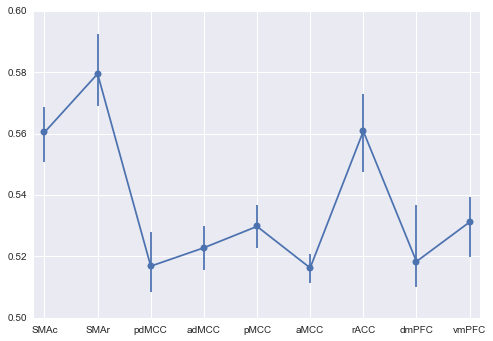

In [27]:
bar_plot_ci('mean_roc_auc', 'lower_roc_auc', 'upper_roc_auc', 'region_name', boot_report_1_grouped, ylim=(0.5, .6))

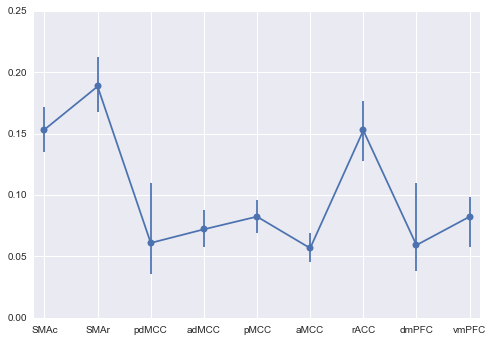

In [28]:
bar_plot_ci('mean_sensitivity', 'lower_sensitivity', 'upper_sensitivity', 'region_name', boot_report_1_grouped, ylim=(0, 0.25))

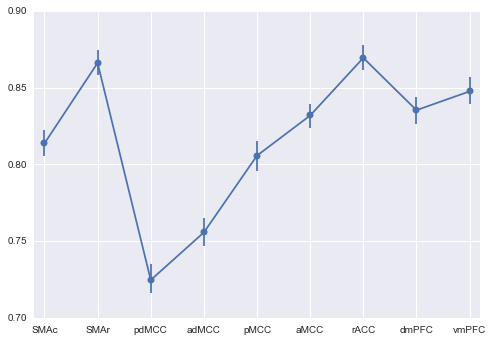

In [29]:
bar_plot_ci('mean_specificity', 'lower_specificity', 'upper_specificity', 'region_name', boot_report_1_grouped, ylim=(0.7, .9))

## 1 - Max Topics classification

In [10]:
def classification_by_topics(args):
    (data, fis, classifier), reg = args
    
    fis_reg = fis[reg, :]
    X, y = data[reg]
    results = []
    for n_topics in range(1, fis_reg.shape[0]):
        for n_boot in range(1, 1000):
            features_ix =  np.argpartition(fis_reg, -n_topics)[-n_topics:]
            samples_ix = np.random.choice(range(1, X.shape[0]), X.shape[0])
            X_i = X[samples_ix][:, features_ix]
            if features_ix.shape[0] == 1:
                X_i = X_i.reshape(-1, 1)
            y = y[samples_ix]
            output_i = classify.classify(
                X_i, y, classifier=classifier, cross_val='4-Fold', scoring = roc_auc_score)
            report = mean_roc_report(output_i['predictions'])
            report['region'] = reg
            report['n_topics'] = n_topics
            report['n_boot'] = n_boot
            results.append(report)
    return results

In [11]:
processes = 1
if processes > 1:
    from multiprocessing import Pool
    pool = Pool(processes=processes)
else:
    pool = itertools

pb = tools.ProgressBar(len(clf.data), start=True)

performance_by_topics = []
regions_iter = range(0, len(clf.data))
for result in pool.imap(classification_by_topics, 
                        itertools.izip(itertools.repeat((clf.data, clf.feature_importances, clf.classifier)), regions_iter)):
    pb.next()
    for row in result:
        performance_by_topics.append(row)

performance_by_topics = pd.DataFrame(performance_by_topics)
performance_by_topics.region += 1

/Users/aleph4/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=4.
  % (min_labels, self.n_folds)), Warning)


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
performance_by_topics['region_name'] = performance_by_topics.region.map(regions)

In [ ]:
sns.set_context('talk')
sns.set_style('ticks')

In [ ]:
sns.lmplot('n_topics', 'roc_auc', performance_by_topics, hue='region_name', fit_reg=False,  palette=nine_colors)

In [ ]:
g = sns.lmplot('n_topics', 'sensitivity', performance_by_topics, hue='region_name', fit_reg=False,  palette=nine_colors)
g.set(ylim=(0, 1))

In [ ]:
g = sns.lmplot('n_topics', 'specificity', performance_by_topics, hue='region_name', fit_reg=False,  palette=nine_colors)
g.set(ylim=(0, 1))

In [ ]:
performance_by_topics.corr()

In [ ]:
from scipy.stats import pearsonr
pearsonr(performance_by_topics.n_topics, performance_by_topics.specificity)